Statistical errors of ANN models

In [98]:
import numpy as np
import torch
if torch.cuda.device_count():
    device = 'cuda'
    print('Good to go')
else:
    device = 'cpu'
    print('Using cpu')

Good to go


In [99]:
#load saved model
from Neural_network import NN_net, Plain_fc_block, weight_init, eMNS_Dataset
num_input = 15
num_output = 3
fc_stages = [(num_input,100,1),(100,50,1),(50,25,1)]
fc_network = NN_net(None,fc_stages,None,Plain_fc_block, num_output=num_output)

fc_network = torch.load('EMS_ANN.pt', map_location="cuda:0")
fc_network.eval()
fc_network.to(device)

NN_net(
  (total_net): Sequential(
    (0): NN_stages(
      (net): Sequential(
        (0): Plain_fc_block(
          (fc): Linear(in_features=15, out_features=100, bias=True)
          (relu): ReLU()
        )
      )
    )
    (1): NN_stages(
      (net): Sequential(
        (0): Plain_fc_block(
          (fc): Linear(in_features=100, out_features=50, bias=True)
          (relu): ReLU()
        )
      )
    )
    (2): NN_stages(
      (net): Sequential(
        (0): Plain_fc_block(
          (fc): Linear(in_features=50, out_features=25, bias=True)
          (relu): ReLU()
        )
      )
    )
    (3): Linear(in_features=25, out_features=3, bias=True)
  )
)

In [113]:
from ReadData import ReadCurrentAndField 
import glob
import os 

# print(os.getcwd())
foldername="./Data/"
filepattern = "MagneticField[0-9]*.txt"
#data = ReadFolder(foldername,filepattern)
train_file_num = 50
data = ReadCurrentAndField (foldername,filepattern)

fileList = glob.glob(foldername+filepattern)

data=data.reshape(1000,21,21,21,18)
position = data[:,0:20:2,0:20:2,0:20:2,:15]
Bfield = data[:,0:20:2,0:20:2,0:20:2,15:]

#find min and max value of input position and Bfield
max_position, max_position_index = torch.max(position.reshape(-1,15), dim=0, keepdim=True)
print(max_position)
min_position, min_position_index = torch.min(position.reshape(-1,15), dim=0, keepdim=True)
print(min_position)

max_Bfield, max_Bfield_index = torch.max(Bfield.reshape(-1,3), dim=0, keepdim=True)
print(max_Bfield)
min_Bfield, min_Bfield_index = torch.min(Bfield.reshape(-1,3), dim=0, keepdim=True)
print(min_Bfield)

print(position.shape)
print(Bfield.shape)


dimp=position.shape
dimB=Bfield.shape

position_norm = (position-min_position.expand(dimp[0],dimp[1],dimp[2],dimp[3],dimp[4]))/(max_position.expand(dimp[0],dimp[1],dimp[2],dimp[3],dimp[4])-min_position.expand(dimp[0],dimp[1],dimp[2],dimp[3],dimp[4]))
Bfield_norm = (Bfield-min_Bfield.expand(dimB[0],dimB[1],dimB[2],dimB[3],dimB[4]))/(max_Bfield.expand(dimB[0],dimB[1],dimB[2],dimB[3],dimB[4])-min_Bfield.expand(dimB[0],dimB[1],dimB[2],dimB[3],dimB[4]))



tensor([[14.9943, 14.9997, 14.9988, 14.9575, 14.9915, 14.9808, 14.9884, 14.9878,
         14.9228, 14.9957, 14.9494, 14.9535,  0.0400,  0.0400,  0.0400]])
tensor([[-14.9800, -14.9944, -14.9792, -14.9903, -14.9597, -14.9911, -14.9693,
         -14.9875, -14.9675, -14.9837, -14.9757, -14.9139,  -0.0500,  -0.0500,
          -0.0500]])
tensor([[0.0525, 0.0638, 0.0538]])
tensor([[-0.0557, -0.0575, -0.0639]])
torch.Size([1000, 10, 10, 10, 15])
torch.Size([1000, 10, 10, 10, 3])


In [118]:
#calculate estimated Bfield value of ANN 

B_est_norm=torch.zeros(10,3,10,10,10)
for i in range (0,10):
    print(i)
    for j in range (0,position.shape[1]):
        for k in range(0,position.shape[2]):
            for l in range(0,position.shape[3]):
                input=position_norm[i,j,k,l,:].cuda(0)
                b = input.float().reshape(1,15)
                B_est_norm[i,:,j,k,l]=fc_network(b)

0
1
2
3
4
5
6
7
8
9


In [119]:
B_est_norm=B_est_norm.cpu().detach().numpy()
Bfield_norm=Bfield_norm.detach().numpy()

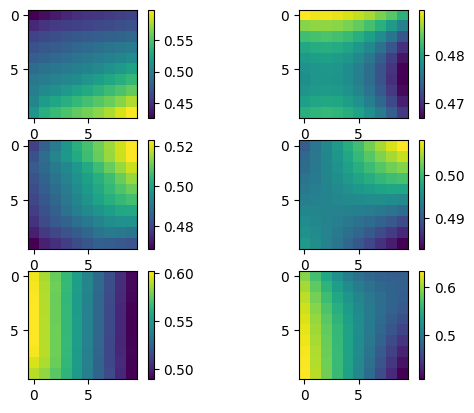

In [145]:
import matplotlib.pyplot as plt
import numpy as np
current_index=8
z_plane_index= 5
# fig, ax = plt.subplots(3, 2)
# fig.tight_layout(h_pad=2)
fig = plt.figure()
vmin=[0.5,  0.4,  0.6]
vmax=[0.65 , 0.55,  0.75]

# fig.tight_layout(pad=0.4, w_pad=0, h_pad=0)
for i in range(1,4):
    plt.subplot(3,2,2*i-1)
    plt.imshow(B_est_norm[current_index,i-1,:,:,z_plane_index])    #,vmin=vmin[i-1],vmax=vmax[i-1]
    plt.colorbar()
  
    plt.subplot(3,2,2*i)
    plt.imshow(Bfield_norm[current_index,:,:,z_plane_index,i-1])
    plt.colorbar()
plt.show()

In [ ]:
# from pylab import *
# subplots_adjust(left=0.0,bottom=0.0,top=1,right=1)
# fig, ax = plt.subplots(1, 3)
# fig.tight_layout()

# for i in range(1,4):
#     plt.subplot(1,3,i)
#     plt.imshow(Error_CNN[current_index,i-1,:,:,z_plane_index])    
#     plt.colorbar(fraction=0.04)    
# plt.show()